* 框架:pytorch
* 网络接口:UNET
* 数据集:天池地表建筑物识别
* 数据集地址以及项目简介:https://tianchi.aliyun.com/competition/entrance/531872/information

In [1]:
#基础环境声明
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
from tqdm import tqdm
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import os
import torch.nn.functional as F
from tqdm import tqdm
import scipy

In [2]:
#基础配置文件
LEARNING_RATE = 1e-4
SPLIT=0.2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2
EPOCHS = 8
NUM_WORKERS = 4
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
PIN_MEMORY = True
DATAPATH = "./build_data/"
TRAIN_IMG_DIR = DATAPATH+'train/train'
TRAIN_MASK_DIR =DATAPATH+ 'train_mask'

In [3]:
DEVICE

'cuda'

In [4]:
import zipfile
def un_zip(file_name):
    """unzip zip file"""
    zip_file = zipfile.ZipFile(file_name)
    if os.path.isdir("./build_data/train"):
        pass
    else:
        os.mkdir("./build_data/train")
    for names in zip_file.namelist():
        zip_file.extract(names, "./build_data/train")
    zip_file.close()

In [5]:
# un_zip("./build_data/source/train.zip")

In [6]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [7]:
def create_sample():
    # 训练标签数据csv转图片
    train_mask = pd.read_csv("./build_data/source/train_mask.csv", sep='\t', names=['name', 'mask'])
    for name,mask in train_mask.values:
        if(pd.isnull(mask)):
            r_dir =TRAIN_IMG_DIR+ '/' +name
            if(os.path.exists(r_dir)):
                os.remove(r_dir)
                print("删除"+r_dir)
            continue;
        mask = rle_decode(mask)
        cv2.imwrite(TRAIN_MASK_DIR+'/'+name.rsplit(".",maxsplit=1)[0]+"_mask.jpg", mask*255)

In [8]:
# create_sample()#删除没有MASK的图片以及将CSV格式图片还原成jpg

In [9]:
#连续两次卷积
def double_conv(in_c, out_c):
    conv = nn.Sequential(#一个时序容器
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),#二维卷积层
        nn.BatchNorm2d(out_c),#标准化
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )
    return conv.to(DEVICE)


In [10]:
#裁剪图片，缩小一半
def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size-target_size
    delta = delta//2
    # all batch, all channels, heightModified,widthModified
    return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]

#图像填充
def addPadding(srcShapeTensor, tensor_whose_shape_isTobechanged):
    if(srcShapeTensor.shape != tensor_whose_shape_isTobechanged.shape):
        target = torch.zeros(srcShapeTensor.shape)
        target[:, :, :tensor_whose_shape_isTobechanged.shape[2],
               :tensor_whose_shape_isTobechanged.shape[3]] = tensor_whose_shape_isTobechanged
        return target.to(DEVICE)
    return tensor_whose_shape_isTobechanged.to(DEVICE)

In [11]:
#定义UNet网络
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )
        self.up_conv_1 = double_conv(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )
        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        )
        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1
        )

    def forward(self, image):
        # 左边下采样编码层
        #第一层
        x1 = self.down_conv_1(image)
        #第二层
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        #第三层
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        #第四层
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        #第五层
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)


        # 右边上采样解码层
        #第六层
        x = self.up_trans_1(x9)
        x = addPadding(x7, x)
        x = self.up_conv_1(torch.cat([x7, x], 1))
        #第七层
        x = self.up_trans_2(x)
        x = addPadding(x5, x)
        x = self.up_conv_2(torch.cat([x5, x], 1))
        #第八层
        x = self.up_trans_3(x)
        x = addPadding(x3, x)
        x = self.up_conv_3(torch.cat([x3, x], 1))
        #第九层
        x = self.up_trans_4(x)
        x = addPadding(x1, x)
        x = self.up_conv_4(torch.cat([x1, x], 1))

        x = self.out(x)
        # print(x.shape)
        return x.to(DEVICE)

In [12]:
class CarvanaDataset(Dataset):
    def __init__(self,images,image_dir,mask_dir,transform=None,train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.isTrain = train
        self.images = images
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img_path = os.path.join(self.image_dir,self.images[index])
        mask_path = os.path.join(self.mask_dir,self.images[index].replace(".jpg","_mask.jpg"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),dtype=np.float32)
        mask[mask == 255.0] = 1.0
        
        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']
            
        return {"image":image,"mask":mask}

In [13]:
images = os.listdir(TRAIN_IMG_DIR)
masks = os.listdir(TRAIN_MASK_DIR)

(512, 512, 3)


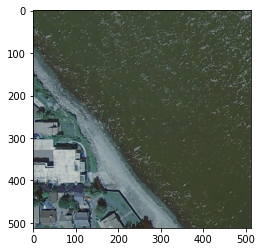

In [14]:
img = np.array(Image.open(TRAIN_IMG_DIR+"/"+images[2]).convert("RGB"))
plt.imshow(img,cmap="gray")
print(img.shape)

(512, 512)


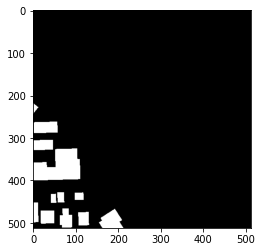

In [15]:
msk = np.array(Image.open(TRAIN_MASK_DIR+"/"+images[2].replace(".jpg","_mask.jpg")).convert("L"))
plt.imshow(msk,cmap="gray")
print(msk.shape)

In [16]:
#喂入数据训练模型
def fit(model,dataloader,data,optimizer,criterion):
    print('-------------开始训练---------------')
    model.train()
    train_running_loss = 0.0
    counter=0
    
    num_batches = int(len(data)/dataloader.batch_size)#计算训练数据分为多少batch
    for i,data in tqdm(enumerate(dataloader),total=num_batches):
        counter+=1
        image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(image)
        outputs =outputs.squeeze(1)
        outputs=F.normalize(outputs,dim=2)
        loss = criterion(outputs,mask)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/counter
    return train_loss

#验证数据模型效果
def validate(model,dataloader,data,criterion):
    print("\n--------验证模型---------\n")
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    num_batches = int(len(data)/dataloader.batch_size)#计算训练数据分为多少batch
    with torch.no_grad():
        for i,data in tqdm(enumerate(dataloader),total=num_batches):
            counter+=1
            image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
            outputs = model(image)
            outputs =outputs.squeeze(1)
            outputs=F.normalize(outputs,dim=2)
            loss = criterion(outputs,mask)
            valid_running_loss += loss.item()
    valid_loss = valid_running_loss/counter
    return valid_loss

In [17]:
import albumentations as A
from albumentations.pytorch import ToTensorV2 
#albumentations可以对数据集进行逐像素的转换
#如模糊、下采样、高斯造点、高斯模糊、动态模糊、RGB转换、随机雾化等；
#也可以进行空间转换（同时也会对目标进行转换）
#如裁剪、翻转、随机裁剪等。
#https://blog.csdn.net/zhangyuexiang123/article/details/107705311 增强方法参考文档

![Rotate](./simage/Rotate.png)

In [18]:
#图像增强相关操作
train_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),#图片大小控制
    A.Rotate(limit=35,p=1.0),#旋转角度35 变换概率1.0
    A.HorizontalFlip(p=0.5),#围绕Y轴水平翻转
    A.VerticalFlip(p=0.1),#围绕X轴垂直翻转
    A.Normalize(#归一化
        mean=[0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0
    ),
    ToTensorV2()  
])
validation_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Normalize(
        mean = [0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2()
])

In [19]:
def train_test_split(images,splitSize):
    imageLen = len(images)
    val_len = int(splitSize*imageLen)
    train_len = imageLen - val_len
    train_images,val_images = images[:train_len],images[train_len:]
    return train_images,val_images

In [20]:
train_images_path,val_images_path = train_test_split(images,SPLIT)
train_data = CarvanaDataset(train_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,train_transform,True)
valid_data = CarvanaDataset(val_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,validation_transform,True)
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
valid_dataloader = DataLoader(valid_data,batch_size=BATCH_SIZE,shuffle=False)

In [ ]:
train_loss = []
val_loss =[]
model = UNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)#优化算法
criterion = nn.BCEWithLogitsLoss()
for epoch in range(EPOCHS):#训练开始epoch
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_dataloader, train_data,optimizer,criterion)
    val_epoch_loss = validate(model, valid_dataloader, valid_data, criterion)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color="orange", label='train loss')
plt.plot(val_loss, color="red", label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"./simage/loss.png")
plt.show()
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
}, "./model.pth")

print("\n---------DONE TRAINING----------\n")

Epoch 1 of 8
-------------开始训练---------------


9919it [39:15,  4.21it/s]                          



--------验证模型---------



2480it [03:46, 10.96it/s]                          


Train Loss: 0.4066
Val Loss: 0.3778
Epoch 2 of 8
-------------开始训练---------------


 63%|██████▎   | 6285/9918 [24:52<14:22,  4.21it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

9919it [39:15,  4.21it/s]                          



--------验证模型---------



 12%|█▏        | 301/2479 [00:27<03:18, 10.96it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

9919it [39:15,  4.21it/s]                          



--------验证模型---------



2480it [03:46, 10.95it/s]                          


Train Loss: 0.3640
Val Loss: 0.3534
Epoch 5 of 8
-------------开始训练---------------


 16%|█▌        | 1551/9918 [06:08<33:08,  4.21it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 73%|███████▎  | 7198/9918 [28:29<10:46,  4.21it/s]

In [27]:
plt.savefig(f"./simage/loss.png")
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
}, "./model.pth")

<Figure size 432x288 with 0 Axes>

torch.Size([512, 512])


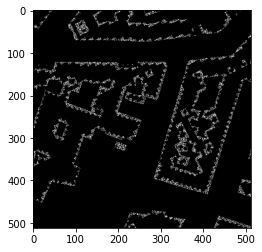

In [28]:
data = train_data.__getitem__(200)
plt.imshow(data['mask'],cmap="gray")
print(train_data.__getitem__(0)['mask'].shape)

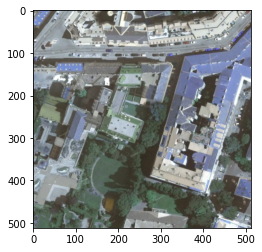

In [29]:
plt.imshow(np.transpose(np.array(data['image']),(1,2,0)),cmap="gray")

torch.Size([3, 512, 512])
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([512, 512])


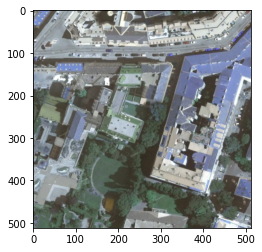

In [30]:
# for Testing on Single datapoint after training
plt.imshow(np.transpose(np.array(data['image']),(1,2,0)),cmap="gray")
print(data['image'].shape)
img = data['image'].unsqueeze(0).to(device="cuda")
# model = UNet()
output = model(img)#预测
output = torch.squeeze(output)
output[output>0.0] = 1.0
output[output<=0.0]=0
print(torch.max(output))
print(output.shape)
disp = output.detach().cpu()
# plt.imshow(disp,cmap="gray")

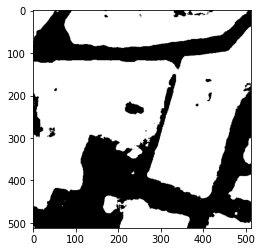

In [31]:
plt.imshow(disp,cmap="gray")